# Example Notebook for trilepton events

In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import pandas as pd
import uproot_methods
import awkward

from memory_profiler import profile

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.helpers import addRowToCutFlow, loadConfig, getCutFlowTable

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "pt_spec_max" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "MT" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "ST" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "mbj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mjj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_ele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_diele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_dimu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_spec" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "FWMT1" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT2" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT3" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT4" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT5" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "S" :               hist.Hist("Counts", dataset_axis, norm_axis),
            "S_lep" :           hist.Hist("Counts", dataset_axis, norm_axis),
            'diboson':          processor.defaultdict_accumulator(int),
            'ttbar':            processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTX':              processor.defaultdict_accumulator(int),
            'tW_scattering':    processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()

        # load all the default candidates (jets, leptons, ...)

        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            goodjet = df['Jet_isGoodJetAll'].content,
            bjet = df['Jet_isGoodBJet'].content,
            jetId = df['Jet_jetId'].content,
            puId = df['Jet_puId'].content,
        )
        jet     = jet[(jet['goodjet']==1)]
        btag    = jet[jet['bjet']==1]
        light   = jet[(jet['goodjet']==1) & (jet['bjet']==0)]

        ## Leptons
        lepton = JaggedCandidateArray.candidatesfromcounts(
            df['nLepton'],
            pt = df['Lepton_pt'].content,
            eta = df['Lepton_eta'].content,
            phi = df['Lepton_phi'].content,
            mass = df['Lepton_mass'].content,
            pdgId = df['Lepton_pdgId'].content,
        )

        ## Muons
        muon = lepton[abs(lepton['pdgId'])==13]
        dimuon = muon.choose(2)
        OSmuon = (dimuon.i0['pdgId'] * dimuon.i1['pdgId'] < 0)
        dimuon = dimuon[OSmuon]

        ## Electrons
        electron = lepton[abs(lepton['pdgId'])==11]
        dielectron = electron.choose(2)
        OSelectron = (dielectron.i0['pdgId'] * dielectron.i1['pdgId'] < 0)
        dielectron = dielectron[OSelectron]

        ## MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]

        ## Event classifieres
        
        
        ## define selections (maybe move to a different file at some point)
        trilep      = ((df['nLepton']==3) & (df['nVetoLepton']>=3))
        twoJet      = (jet.counts>2) # those are any two jets
        oneBTag     = (btag.counts>0)
        twoMuon     = ( muon.counts==2 )
        #Zveto_mu    = ( (dimuon.counts<1) )# | (abs(dimuon.mass - 91)>15) )
        Zveto_mu    = ( ((dimuon.mass-91.)>15).counts<1 )
        Zveto_ele   = ( ((dielectron.mass-91.)>15).counts<1 )
        met         = (met_pt > 50)


        ## work on the cutflow
        output['totalEvents']['all'] += len(df['weight'])

        addRowToCutFlow( output, df, cfg, 'skim',        None ) # entry point
        addRowToCutFlow( output, df, cfg, 'trilep',      trilep )
        addRowToCutFlow( output, df, cfg, 'twoJet',      trilep & twoJet )
        addRowToCutFlow( output, df, cfg, 'oneBTag',     trilep & twoJet & oneBTag )
        addRowToCutFlow( output, df, cfg, 'met50',       trilep & twoJet & oneBTag & met )
        addRowToCutFlow( output, df, cfg, 'dimuon',      trilep & twoJet & oneBTag & met & twoMuon )
        addRowToCutFlow( output, df, cfg, 'Zveto_mu',    trilep & twoJet & oneBTag & met & Zveto_mu )
        addRowToCutFlow( output, df, cfg, 'Zveto',       trilep & twoJet & oneBTag & met & Zveto_mu & Zveto_ele )

        # preselection of events
        event_selection = trilep & twoJet & oneBTag & met
        
        ## And fill the histograms
        # just the number of electrons and muons
        output['N_ele'].fill(dataset=dataset, multiplicity=electron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_mu'].fill(dataset=dataset, multiplicity=muon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])

        # something a bit more tricky
        output['N_diele'].fill(dataset=dataset, multiplicity=dielectron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_dimu'].fill(dataset=dataset, multiplicity=dimuon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])

        return output

    def postprocess(self, accumulator):
        return accumulator


In [3]:
overwrite = False
small = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'triLep_small' if small else 'triLep'

from samples import fileset, fileset_small, fileset_3l

# histograms
histograms = []
histograms += ['N_ele', 'N_mu', 'N_diele', 'N_dimu']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_small
        workers = 1
    else:
        fileset = fileset_3l
        workers = 8
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()



/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


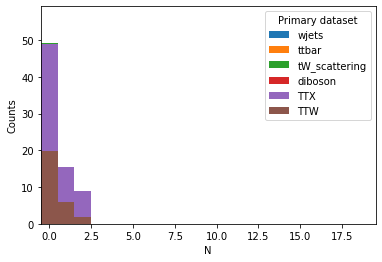

In [4]:
histogram = output['N_diele']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


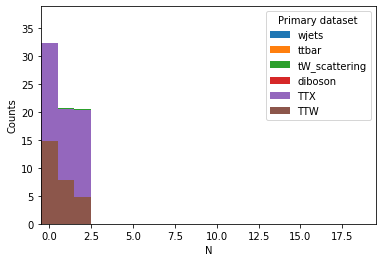

In [5]:
histogram = output['N_dimu']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

In [6]:
df = getCutFlowTable(output, processes=['tW_scattering', 'ttbar', 'diboson'], lines=['skim', 'twoJet'])

        tW_scattering        ttbar     diboson
skim       123.662890  9741.338940  726.373038
twoJet       0.514726     0.160328    0.000000
